# Visualize and impute the Missing value

This notebook is the companion code for the article dedicated to missing value. Check the article here to deep dive in the theory

In [19]:
%%capture
!pip install datasets
!pip install upsetplot
!pip install wget
!pip install qolmat
!pip install MIDASpy

In [2]:
import numpy as np

def introduce_missing_values(dataset, missing_percentage):
    """
    Introduces random missing values into a dataset.

    Parameters:
    dataset (numpy.ndarray): The input dataset.
    missing_percentage (float): The percentage of missing values to introduce, expressed as a float between 0 and 1.

    Returns:
    numpy.ndarray: The dataset with missing values introduced.
    """
    dataset = dataset.astype(float)
    # Calculate the number of missing values to introduce
    num_missing = int(dataset.size * missing_percentage)

    # Generate random indices to place missing values
    missing_indices = np.random.choice(dataset.size, num_missing, replace=False)

    # Flatten the dataset and introduce missing values at random indices
    flattened_dataset = dataset.flatten()
    flattened_dataset[missing_indices] = np.nan

    # Reshape the dataset back to its original shape
    dataset_with_missing = flattened_dataset.reshape(dataset.shape)

    return dataset_with_missing

def plot_upset(data = None):
  """
  plot an upset plot for missing data
  take an input a dataframe
  Example usage:
  import pandas as pd
  df = pd.read_csv("https://raw.githubusercontent.com/SalvatoreRa/tutorial/main/datasets/titanic.csv")
  plot_upset(data = df)
  """
  try:
    import upsetplot
  except ModuleNotFoundError:
    print("install upsetplot: !pip install upsetplot")
    pass
  import pandas as pd
  from upsetplot import plot, from_contents, from_indicators, UpSet
  na_list = data.columns[data.isna().any()].tolist()
  data = data[data.columns.intersection(na_list)]
  data = data.mask(data.isnull()== True, True)
  data =data.mask(data != True, False)
  data =data.astype('bool')
  UpSet(from_indicators(data.columns.to_list(),data=data)).plot()


In [3]:
import pandas as pd
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import missingno as msno
from upsetplot import plot

Text(0, 0.5, 'regressor performance')

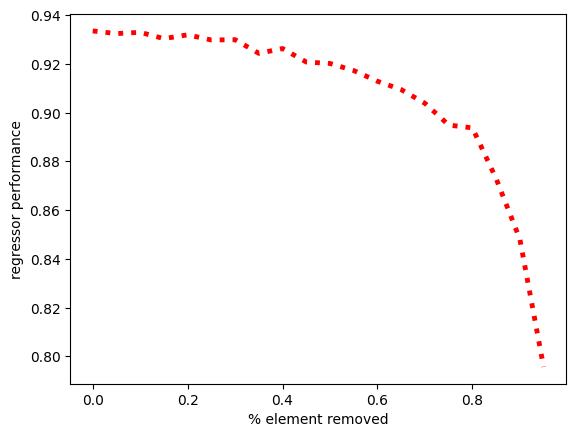

In [30]:
data_dir = "https://raw.githubusercontent.com/SalvatoreRa/tutorial/main/datasets/"
j = 'pol'
df = pd.read_csv(data_dir+j +'.csv',sep=';')

na_size = []
scores =[]
for i in np.arange(0., 0.99, 0.05):


  X, y = df.iloc[:, :-1], df.iloc[:, -1]
  #y = np.where(y=='P',1,0)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  if i != 0:
    X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=i, random_state=42)

  model = xgb.XGBRegressor( random_state=0)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  na_size.append(np.round(i,2))
  scores.append(model.score(X_test, y_test))
plt.plot(na_size, scores, linestyle = 'dotted', color = 'r', linewidth = '3.5')
plt.xlabel('% element removed')
plt.ylabel('regressor performance')

## Missing value visualization


<Axes: >

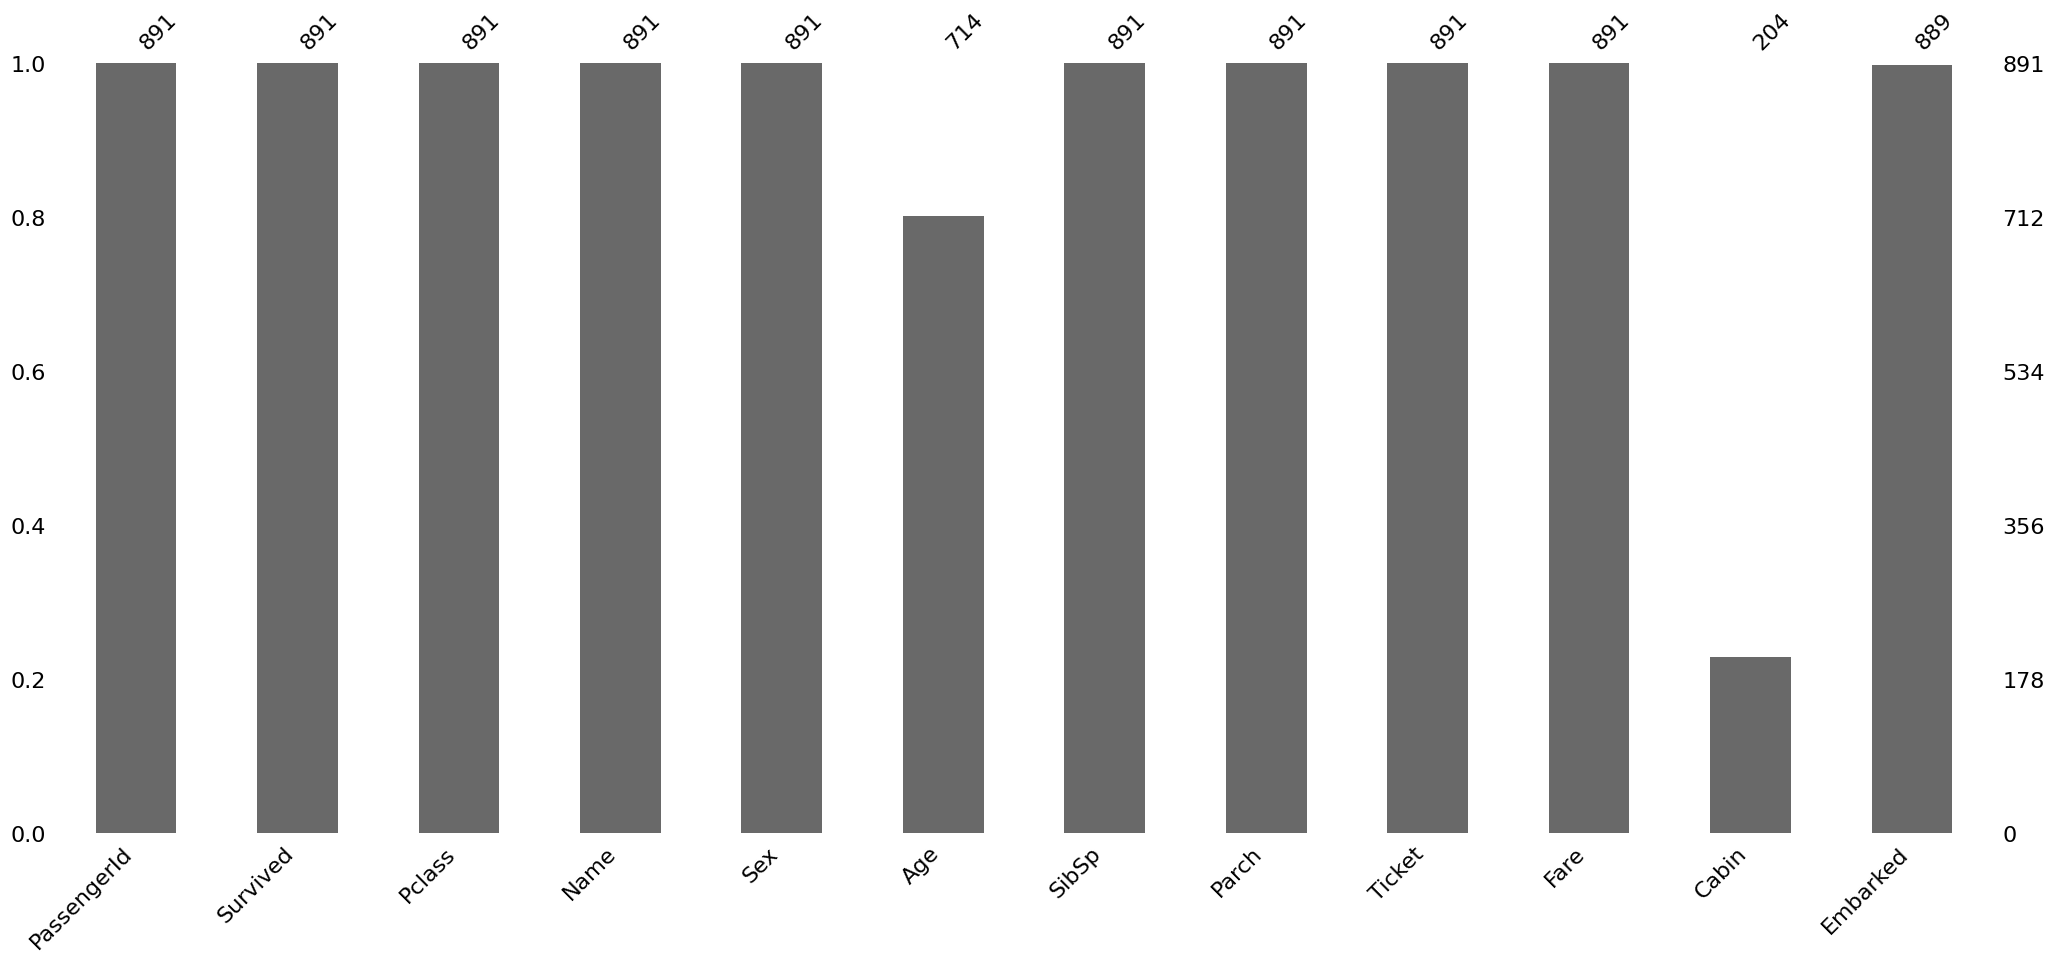

In [5]:
#detecting missing value
df = pd.read_csv("https://raw.githubusercontent.com/SalvatoreRa/tutorial/main/datasets/titanic.csv")
msno.bar(df)

<Axes: >

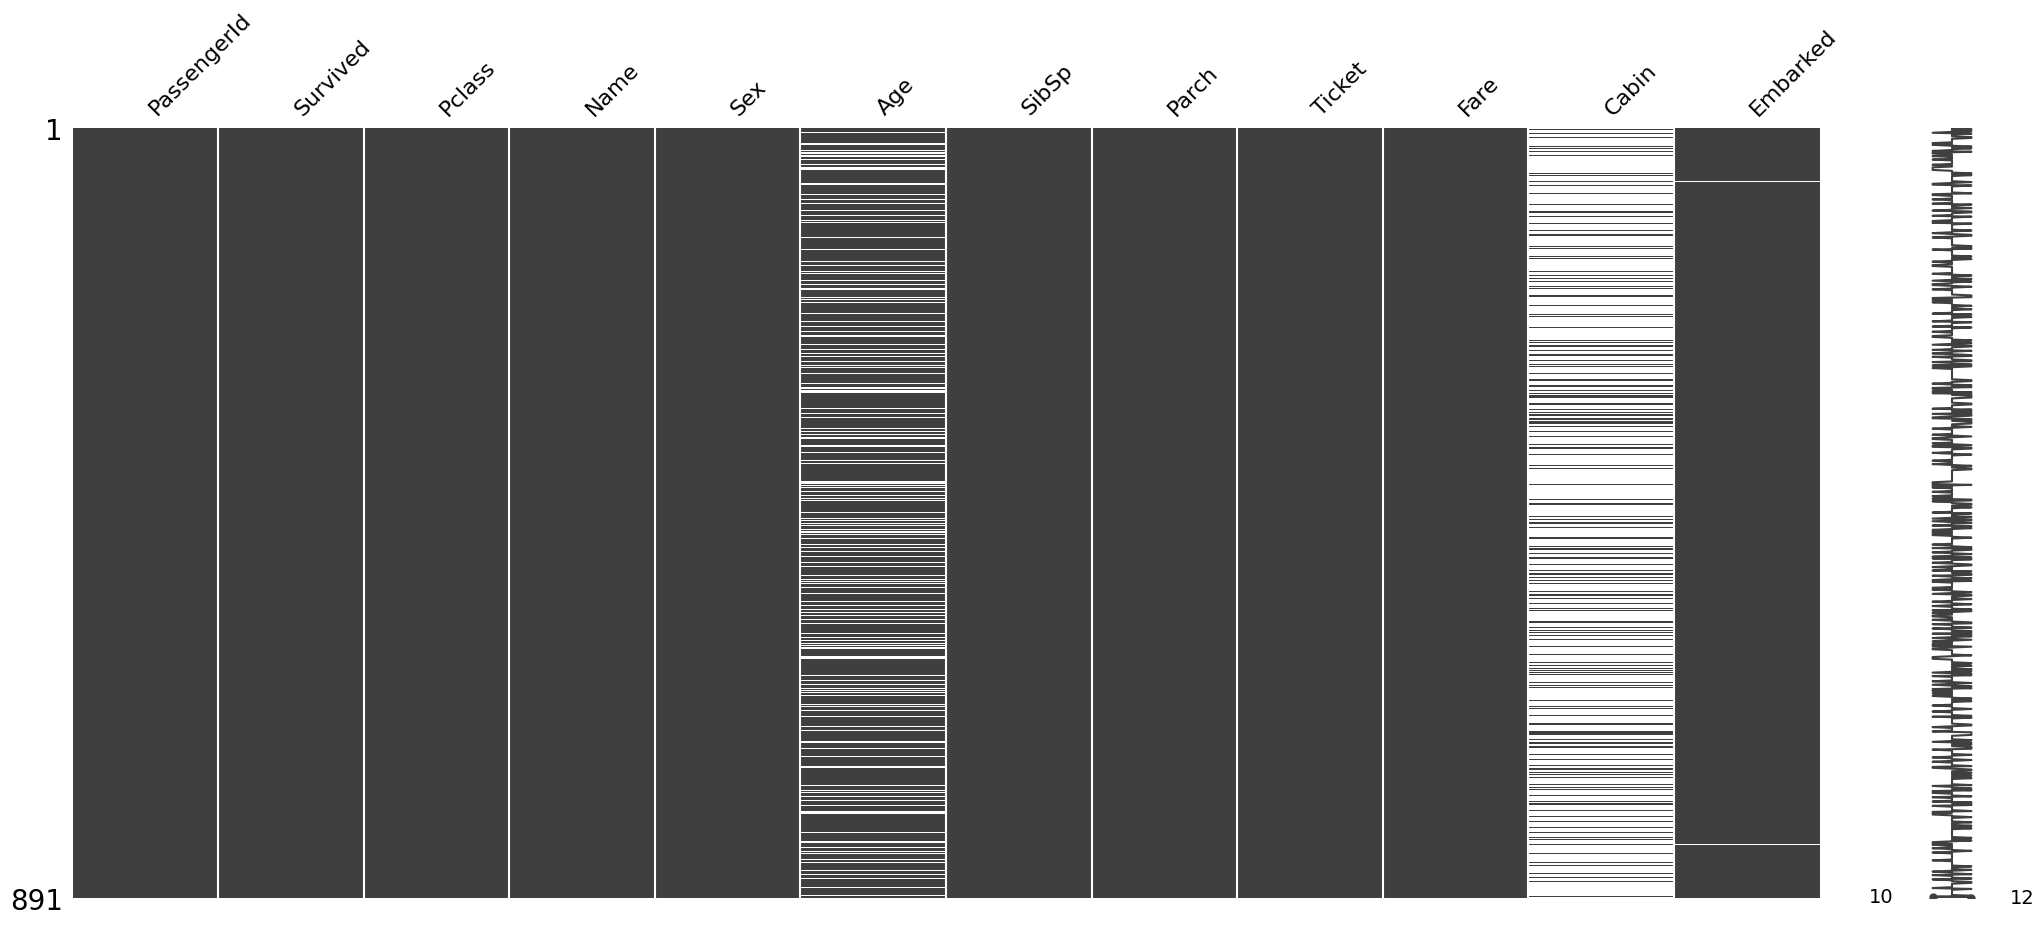

In [6]:
msno.matrix(df)
# msno.matrix(df.sample(100)) #if you want to check just a sample of the data

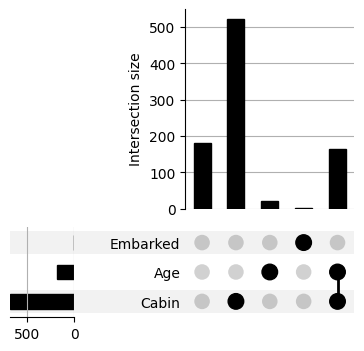

In [7]:
plot_upset(data = df)

<Axes: >

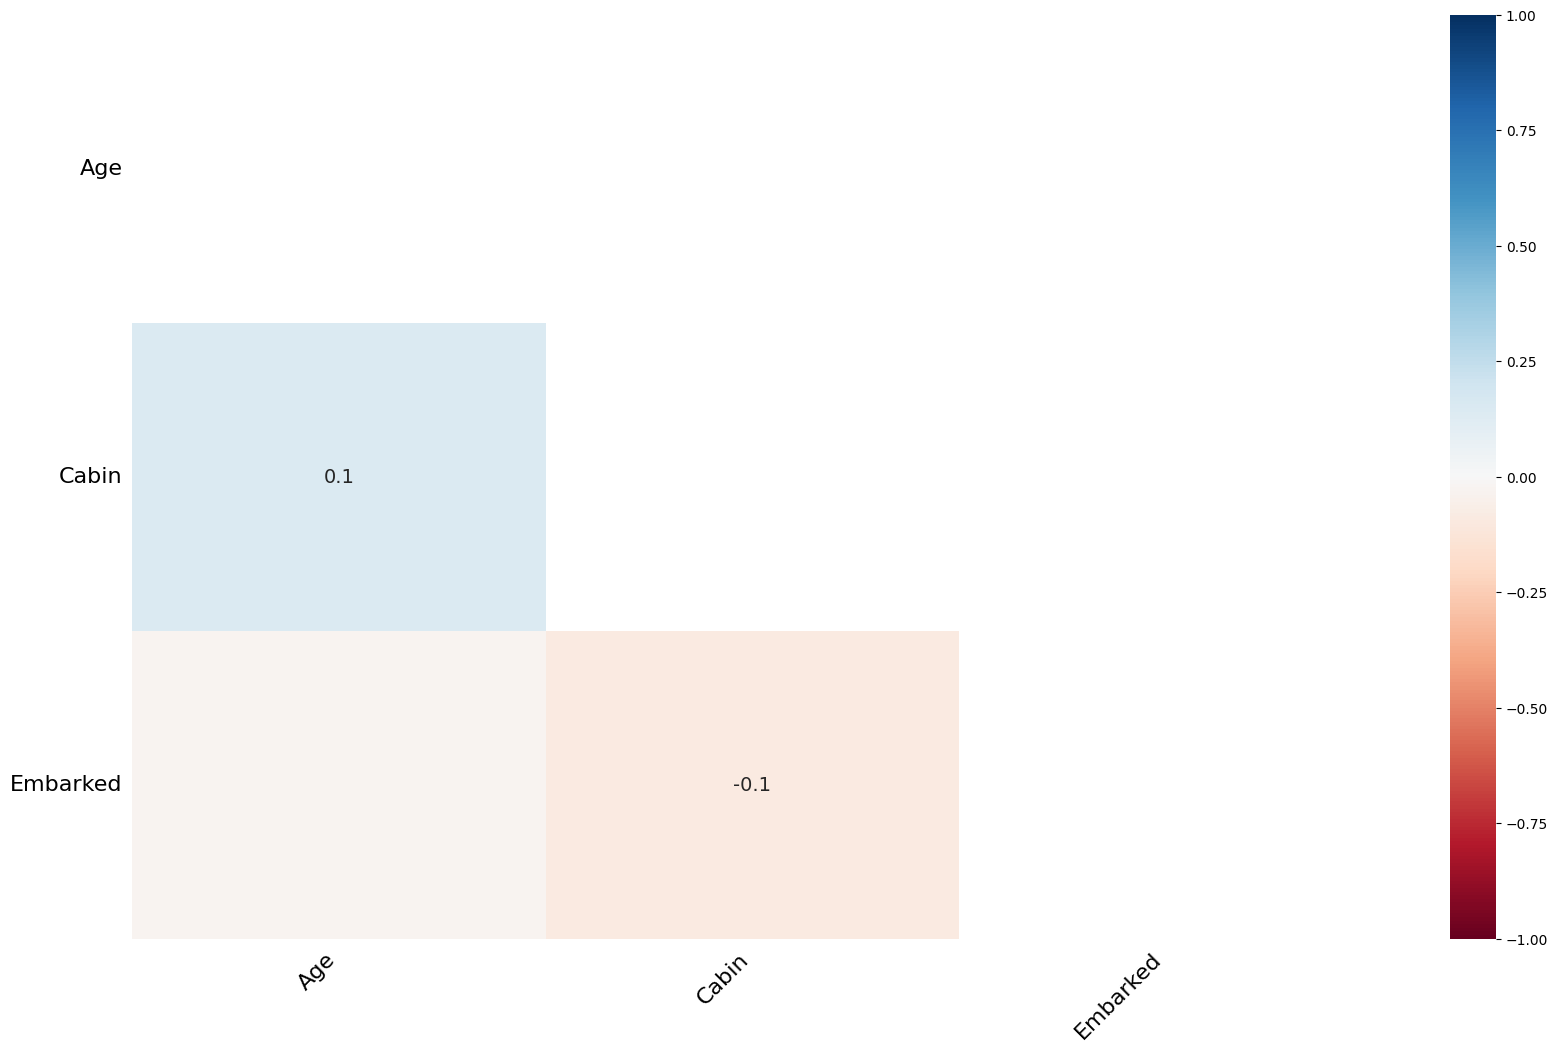

In [8]:
msno.heatmap(df)

<Axes: >

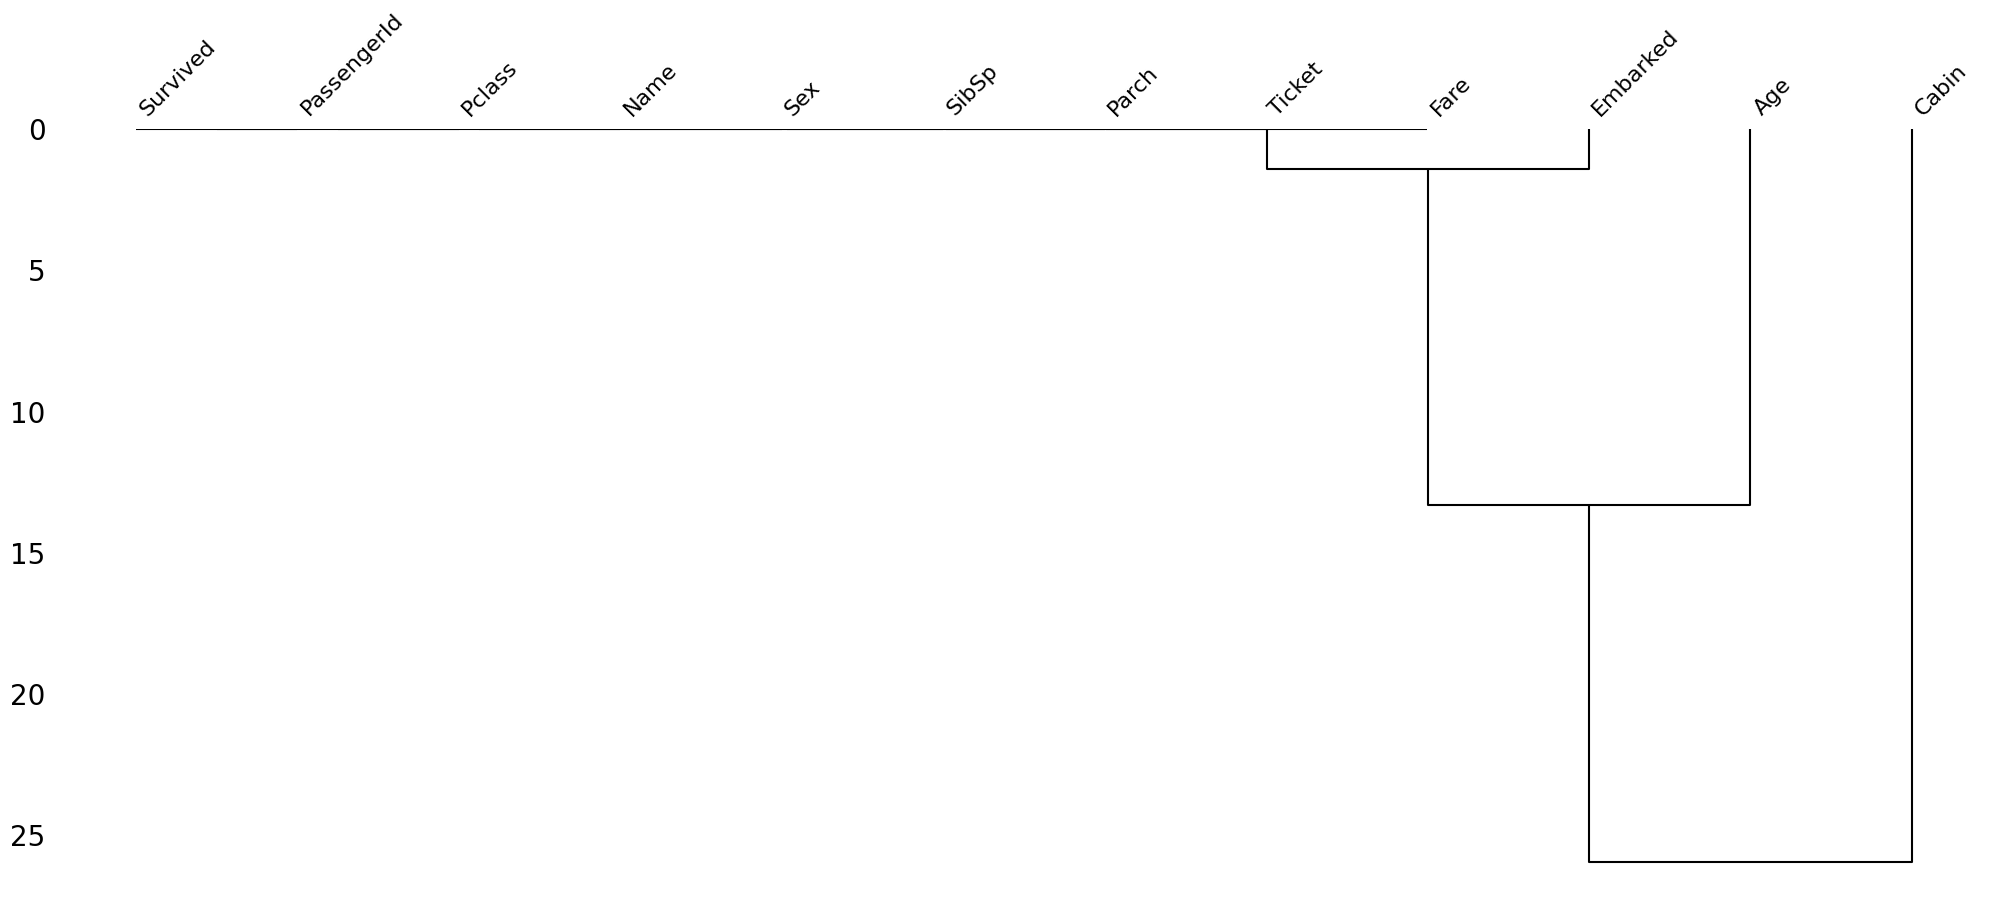

In [9]:
msno.dendrogram(df)

In [10]:
import wget

wget.download('https://raw.githubusercontent.com/SalvatoreRa/tutorial/main/machine learning/utility/utils_NA.py')

from utils_NA import *
import torch
import seaborn as sns

missing_table= missing_values_table(df)
missing_table

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


## Imputation

In [11]:
#Drop the rows with at least one element missing
df.dropna(inplace = True)
# Drop the rows with all the elements missing
df.dropna(how='all',inplace = True)
# Drop the rows with missing values greater than two
df.dropna(thresh=2, inplace = True)
# Drop the rows with at least one missing value in the columns specified in the subset function
#df.dropna(subset=['age', 'fare'])
# Drop the columns with at least one missing value
df.dropna(axis= 1 , inplace = True)
# Drop the columns containing all the elements missing
df.dropna(axis= 'columns',how = 'all', inplace = True)

In [12]:
# Generation of NA
# You can generate different type of NA
df =dataset[ "train"].to_pandas()
X_miss_mcar = produce_NA(df, p_miss=0.4, mecha="MCAR")
X_miss_mar = produce_NA(df, p_miss=0.4, mecha="MAR", p_obs=0.5)
X_miss_mnar = produce_NA(df, p_miss=0.4, mecha="MNAR", opt="logistic", p_obs=0.5)
X_miss_quant = produce_NA(df, p_miss=0.4, mecha="MNAR", opt="quantile", p_obs=0.5, q=0.3)

In [13]:
# Simple imputers
X_miss_mcar = X_miss_mcar['X_incomp'].detach().numpy()
from sklearn.impute import SimpleImputer
X_miss_mcar = np.where(X_miss_mcar=='nan', np.nan, X_miss_mcar )
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_miss_mcar)
print(imp.transform(X_miss_mcar))

[[ 7.22310345  0.3408093   0.         ...  0.56       10.50290993
   5.81871197]
 [ 7.22310345  0.3408093   0.         ...  0.52984682  9.80000019
   5.        ]
 [ 7.80000019  0.75999999  0.32054254 ...  0.52984682  9.80000019
   5.81871197]
 ...
 [ 7.22310345  0.23999999  0.19       ...  0.46000001 10.50290993
   5.81871197]
 [ 5.5         0.28999999  0.32054254 ...  0.52984682 12.80000019
   7.        ]
 [ 6.          0.3408093   0.38       ...  0.52984682 10.50290993
   5.81871197]]


In [14]:
# Median
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_miss_mcar)
imputed = imp.transform(X_miss_mcar)
# zero imputation
imp = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
imp.fit(X_miss_mcar)
imputed = imp.transform(X_miss_mcar)

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import  KNNImputer, IterativeImputer
# KNN imputer
imp = KNNImputer(missing_values=np.nan)
imp.fit(X_miss_mcar)
imputed = imp.transform(X_miss_mcar)
# Imputation with Iterative imputer
imp = IterativeImputer(random_state=0)
imp.fit(X_miss_mcar)
imputed = imp.transform(X_miss_mcar)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [26]:
from qolmat.imputations.diffusions.ddpms import TabDDPM
from qolmat.benchmark import metrics
from qolmat.imputations import imputers

# knnimputers from Qolmat
imp = imputers.ImputerKNN()
imp.fit_transform(pd.DataFrame(X_miss_mcar))
# using EM
# This class implements an imputation method based on joint modelling and
# an inference using a Expectation-Minimization algorithm.
imp = imputers.ImputerEM()
imp.fit_transform(pd.DataFrame(X_miss_mcar))
# use diffusion model for imputing
imp = TabDDPM()
imp.fit(pd.DataFrame(X_miss_mcar))
imputed = imp.predict(pd.DataFrame(X_miss_mcar))


In [29]:
# Imputation with MIDAS
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import MIDASpy as md

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_miss_mcar)
X_train_scaled = pd.DataFrame(X_train_scaled, columns =[str(i) for i in range(X_miss_mcar.shape[1])] )
na_loc = X_train_scaled.isnull()
X_train_scaled[na_loc] = np.nan
imputer = md.Midas(layer_structure= [16,16], vae_layer = False, seed= 89, input_drop = 0.75)
imputer.build_model(X_train_scaled)
imputer.train_model(training_epochs = 15)
imputations = imputer.generate_samples(m=10).output_list
stacked_array = np.stack(imputations)
X_train_imp = np.mean(stacked_array, axis=0)

Size index: [12]

Computation graph constructed

Model initialised

Epoch: 0 , loss: 1.6330974231212598
Epoch: 1 , loss: 1.2268866570712311
Epoch: 2 , loss: 1.0154882460979406
Epoch: 3 , loss: 0.905285641477613
Epoch: 4 , loss: 0.8419457033937201
Epoch: 5 , loss: 0.8146960752938182
Epoch: 6 , loss: 0.7930091434511645
Epoch: 7 , loss: 0.779772288987202
Epoch: 8 , loss: 0.7693067749439202
Epoch: 9 , loss: 0.7634844363029367
Epoch: 10 , loss: 0.7571351810041906
Epoch: 11 , loss: 0.7519664268188289
Epoch: 12 , loss: 0.7513437842207001
Epoch: 13 , loss: 0.7456648746147532
Epoch: 14 , loss: 0.7439923126415666
Training complete. Saving file...
Model saved in file: tmp/MIDAS
Model restored.
